In [34]:
import easyocr
import cv2
from Levenshtein import distance, ratio
from fuzzywuzzy import fuzz
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
import ast

In [2]:
import pandas as pd
import numpy as np
from glob import  glob
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
imgpath = './images/img.png'

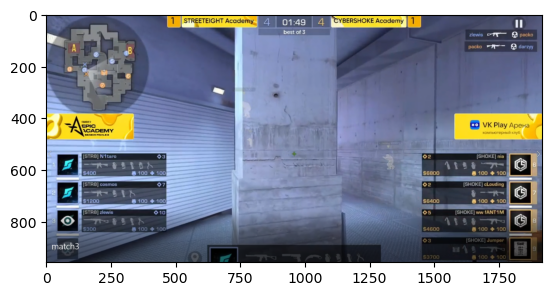

In [4]:
plt.imshow(plt.imread(imgpath))

In [8]:
def preprocess_video(input_video_path: str, output_video_path: str, crop_region: tuple):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        raise IOError('Cannot open video file')
    frame_with = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f'Original video {input_video_path}: {frame_with}x{frame_height}, {fps} FPS, {total_frames} total frames')
    x, y, w, h = (1500, 0, frame_with, frame_height)
    # x, y, w, h = crop_region
    fourcc = cv2.VideoWriter_fourcc(*'mpv4') # Codec for mp4
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (w, h))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cropped_frame = frame[y:y+h, x:x+w]
        out.write(cropped_frame)

    cap.release()
    out.release()
    print(f'Processed Video saved to {output_video_path}')

In [9]:
input_video_path = './video/test_crop.mp4'
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise IOError('Cannot open video file')
frame_with = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'Original video {input_video_path}: {frame_with}x{frame_height}, {fps} FPS, {total_frames} total frames')

Original video ./video/test_crop.mp4: 1280x720, 30 FPS, 1547 total frames


In [17]:
process_frames = []
tenPercentFrames = total_frames / 10 
for i in range(1, 10):
    process_frames.append((int(tenPercentFrames * i), i * 10))

In [18]:
process_frames

[(154, 10),
 (309, 20),
 (464, 30),
 (618, 40),
 (773, 50),
 (928, 60),
 (1082, 70),
 (1237, 80),
 (1392, 90)]

In [19]:
print(1500/1980*1280)

969.6969696969697


In [20]:
reader = easyocr.Reader(['en'], gpu=True)

In [21]:
type(reader)

easyocr.easyocr.Reader

In [136]:
all_kills_df = pd.read_csv('all_kills.csv')
all_kills_df.dropna(inplace=True)
all_kills_df['bbox'] = all_kills_df['bbox'].apply(ast.literal_eval)

In [141]:
nicknames = ['N1taro', 'cosmos', 'darzyy', 'zlewis', 'v1ZUAL', 'cLouding', 'ww fANT1M', 'nia', 'Jumper', 'packoo']

In [137]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s
0,0,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.565397,0.933333
1,1,"[[263, 49], [285, 49], [285, 61], [263, 61]]",nia,0.296140,0.933333
2,2,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.592913,0.966667
3,3,"[[261, 49], [285, 49], [285, 61], [261, 61]]",nia,0.381045,0.966667
4,4,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NIteru,0.409679,1.000000
...,...,...,...,...,...
1864,1864,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.720734,89.700000
1865,1865,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.733333
1866,1866,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.700355,89.733333
1867,1867,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.766667


In [138]:
for i, row in all_kills_df.iterrows():
    for nickname in nicknames:
        if ratio(nickname, row['text']) > 0.7:
            all_kills_df.at[i, 'nickname'] = nickname
            break

In [142]:
centers_x = []
centers_y = []
for i, row in all_kills_df.iterrows():
    (top_left, top_right, bottom_right, bottom_left) = row['bbox']
    centers_x.append((top_left[0] + top_right[0]) / 2)
    centers_y.append((top_left[1] + bottom_left[1]) / 2)
all_kills_df['center_x'] = centers_x
all_kills_df['center_y'] = centers_y

In [146]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s,nickname,center_x,center_y
0,0,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.565397,0.933333,N1taro,148.0,54.0
1,1,"[[263, 49], [285, 49], [285, 61], [263, 61]]",nia,0.296140,0.933333,nia,274.0,55.0
2,2,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.592913,0.966667,N1taro,148.0,54.0
3,3,"[[261, 49], [285, 49], [285, 61], [261, 61]]",nia,0.381045,0.966667,nia,273.0,55.0
4,4,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NIteru,0.409679,1.000000,NaN,148.0,54.0
...,...,...,...,...,...,...,...,...
1864,1864,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.720734,89.700000,cLouding,265.0,55.0
1865,1865,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.733333,zlewis,104.0,54.0
1866,1866,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.700355,89.733333,cLouding,265.0,55.0
1867,1867,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.766667,zlewis,104.0,54.0


# Будем брать значения, у которых y = 55 или 85 c std = 2

In [153]:
filtered_df = all_kills_df[all_kills_df['nickname'].notna()]
filtered_df = filtered_df.query('center_y > 53 & center_y < 57 | center_y > 83 & center_y < 87 & center_x > ')

In [168]:
filtered_df

,Unnamed: 0,bbox,text,conf,time_s,nickname,center_x,center_y
0,0,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.565397,0.933333,N1taro,148.0,54.0
1,1,"[[263, 49], [285, 49], [285, 61], [263, 61]]",nia,0.296140,0.933333,nia,274.0,55.0
2,2,"[[123, 47], [173, 47], [173, 61], [123, 61]]",NItaro,0.592913,0.966667,N1taro,148.0,54.0
3,3,"[[261, 49], [285, 49], [285, 61], [261, 61]]",nia,0.381045,0.966667,nia,273.0,55.0
5,5,"[[261, 47], [285, 47], [285, 61], [261, 61]]",nia,0.917480,1.000000,nia,273.0,54.0
...,...,...,...,...,...,...,...,...
1864,1864,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.720734,89.700000,cLouding,265.0,55.0
1865,1865,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.733333,zlewis,104.0,54.0
1866,1866,"[[237, 47], [293, 47], [293, 63], [237, 63]]",cLouding,0.700355,89.733333,cLouding,265.0,55.0
1867,1867,"[[85, 47], [123, 47], [123, 61], [85, 61]]",zlewuls,0.877060,89.766667,zlewis,104.0,54.0


In [51]:
cleared_words = []
for i, word in enumerate(words):
    should_remove = True
    for nickname in nicknames:
        # print(f'nickname: {nickname}, word {word}, ration {ratio(nickname, word)}')
        if ratio(nickname, word) > 0.7:
            should_remove = False
    if not should_remove:
        cleared_words.append(word) 

In [52]:
# Calculate similarity matrix
n = len(cleared_words)
similarity_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        similarity_matrix[i][j] = ratio(cleared_words[i], cleared_words[j])  # Use Levenshtein ratio

In [ ]:
# Convert similarity to distance (1 - similarity)
distance_matrix = 1 - similarity_matrix

# Apply clustering
clustering = AgglomerativeClustering(n_clusters=None, affinity='precomputed', linkage='complete', distance_threshold=0.3)
labels = clustering.fit_predict(distance_matrix)

In [54]:
clustering.n_clusters_

45

In [55]:
# Group words by clusters
clusters = {}
for word, label in zip(cleared_words, labels):
    clusters.setdefault(label, []).append(word)

In [56]:
# Print results
for cluster_id, cluster_words in clusters.items():
    print(f"Cluster {cluster_id}: {cluster_words}")

Cluster 5: ['NItaro', 'Nitaro', 'Nitar', 'Ntaro', 'Ntearo', 'Ntlaro', 'Nttaro']
Cluster 28: ['nia', 'nia ']
Cluster 23: ['packoo', 'packod', 'packou', 'packon', 'packop', 'packoa', 'packdo', 'packob']
Cluster 4: ['cosmos', 'cosmos 1', 'cusmos']
Cluster 21: ['zlewis', 'zlewwis', 'ziewis', 'zlewis:', 'zlewvis']
Cluster 0: ['Jumper', 'Jumpor', 'Jumiplr', 'Jumiper', 'JJumper', 'Jumpur', 'Jumpar']
Cluster 14: ['MZUAL', '1ZUAL', 'TZUAL', 'JZUAL', 'IZUAL']
Cluster 32: ['~paokoo', 'paokoo']
Cluster 9: ['darzw', 'darzvy', 'darzwy', 'darzyv', 'darzv', 'darzn']
Cluster 17: ['cLuuding', 'cLaudinu', 'cLaudina', 'cLuudinu', 'cLauding']
Cluster 19: ['darzyy', 'darzty', 'darzy', 'darzyy-']
Cluster 10: ['Ilewis', 'dewis', 'Zlewis']
Cluster 36: ['cLouding', 'cLoudlng', 'cLouding ', 'cLooding']
Cluster 42: ['zlewvib', 'zlewib', 'zewib']
Cluster 11: ['Ww fANTIM', 'Wnw fANTIM', 'Ww fANT', 'Ww fANTTM', 'W fANTIM']
Cluster 13: ['dariy', 'darzi']
Cluster 2: ['uckoo', 'puckoo', 'prckoo', 'pockoo']
Cluster 15: 

In [97]:
clusters.get(1)

['zlewia', 'zlewvig', 'zlewig', 'zlewvid', 'zlewie', 'zle wig', 'zlewjig']

In [78]:
def cluster_similarity(cluster1: list, cluster2: list) -> float:
    similarities = []
    for word1 in cluster1:
        for word2 in cluster2:
            similarities.append(ratio(word1, word2))
    # Return the average similarity
    return float(np.mean(similarities))

In [79]:
v = cluster_similarity(clusters.get(11), clusters.get(17))
print(float(v))

0.022222222222222223


In [67]:
type(clusters)

dict

In [81]:
clusters_similarity_matrix = np.zeros((n, n))
clusters_similarity_threshold = 0.6
for i in clusters:
    for j in clusters:
        same_clusters = False
        similarity_value = cluster_similarity(clusters.get(i), clusters.get(j))
        clusters_similarity_matrix[i][j] = similarity_value > clusters_similarity_threshold

In [90]:
def dfs(node, similarity_matrix_parameter, visited, component, n):
    visited[node] = True
    component.append(node)
    for i in range(n):
        if similarity_matrix_parameter[node][i] and not visited[i]:
            dfs(i, similarity_matrix_parameter, visited, component, n)

def find_clusters(similarity_matrix_parameter):
    n = len(similarity_matrix_parameter)  # Number of elements (words)
    visited = [False] * n  # Track visited nodes
    clusters_parameter = []  # List to store the clusters

    for i in range(n):
        if not visited[i]:
            component = []  # Start a new component (cluster)
            dfs(i, similarity_matrix_parameter, visited, component, n)
            clusters_parameter.append(component)  # Add the component to the clusters list

    return clusters_parameter

In [91]:
cls = find_clusters(clusters_similarity_matrix)

{5: ['NItaro', 'Nitaro', 'Nitar', 'Ntaro', 'Ntearo', 'Ntlaro', 'Nttaro'],
 28: ['nia', 'nia '],
 23: ['packoo',
  'packod',
  'packou',
  'packon',
  'packop',
  'packoa',
  'packdo',
  'packob'],
 4: ['cosmos', 'cosmos 1', 'cusmos'],
 21: ['zlewis', 'zlewwis', 'ziewis', 'zlewis:', 'zlewvis'],
 0: ['Jumper', 'Jumpor', 'Jumiplr', 'Jumiper', 'JJumper', 'Jumpur', 'Jumpar'],
 14: ['MZUAL', '1ZUAL', 'TZUAL', 'JZUAL', 'IZUAL'],
 32: ['~paokoo', 'paokoo'],
 9: ['darzw', 'darzvy', 'darzwy', 'darzyv', 'darzv', 'darzn'],
 17: ['cLuuding', 'cLaudinu', 'cLaudina', 'cLuudinu', 'cLauding'],
 19: ['darzyy', 'darzty', 'darzy', 'darzyy-'],
 10: ['Ilewis', 'dewis', 'Zlewis'],
 36: ['cLouding', 'cLoudlng', 'cLouding ', 'cLooding'],
 42: ['zlewvib', 'zlewib', 'zewib'],
 11: ['Ww fANTIM', 'Wnw fANTIM', 'Ww fANT', 'Ww fANTTM', 'W fANTIM'],
 13: ['dariy', 'darzi'],
 2: ['uckoo', 'puckoo', 'prckoo', 'pockoo'],
 15: ['cosmob', 'cosmiog', 'cosmog'],
 22: ['V1ZUAL', 'VZUAL', '@VI1ZUAL'],
 12: ['clouding', 'ctoud

In [115]:
cluster_words = set()
final_clusters = list()
i: int = 0
for cl in cls:
    for cluster_idx in cl:
        wrds = clusters.get(cluster_idx)
        if wrds is None:
            continue
        for wrd in clusters.get(cluster_idx):
            cluster_words.add(wrd)
    if len(cluster_words) > 0:
        final_clusters.append(cluster_words)
    cluster_words = set()

In [119]:
pd.DataFrame(final_clusters)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Jumpor,Jumpen,Jumnner,Jumiplr,Jumpei,Jumiper,umpet,Junper,Jumper,JJumper,...,None,None,None,None,None,None,None,None,None,None
1,zlewis:,zlewia,zlewib,zewib,zlewie,lawis,zlewvib,zlewvis,zlewls,zlewvig,...,zlewwis,zlewvid,zlowis,zlawis,zlewjig,zle wig,dewis,zletwis,Ilewis,zletis
2,packon,uckoo,packop,prckoo,packod,pockoo,paokoo,packoo 100Y,packoo,packob,...,Dackoo,None,None,None,None,None,None,None,None,None
3,cosmiog,Gosmos,cobmos,cosmob,cosmos,Cosmos,cosmog,cormos,cogmos,coamnos,...,cusmos,None,None,None,None,None,None,None,None,None
4,NTtro,Ntlaro,Ntearo,NItaro,NTtaro,Ntaro,Itaro,Nitaro,Nttaro,Nitar,...,None,None,None,None,None,None,None,None,None,None
5,Www [ANTIM,Ww FANT1M,Ww IANT1M,Wnw fANTIM,ww FANT IM,Ww fANT,Wwv FANT1M,Www FANTIM,Ww fANTIM,W fANTIM,...,None,None,None,None,None,None,None,None,None,None
6,ctouding,Elouding,cLoudlng,cLauding,ELoudinn,clouding,aLouding,cLaudina,cLuudinu,cLooding,...,cLowditin,cLouding,cLouding,oLouding,eLoudinu,None,None,None,None,None
7,durzyy,darzwy,darryy,darzi,derzyy,dariy,darzyv,darzty,darzy,darzyy-,...,darzn,darzvy,dlerzyy,darzv,None,None,None,None,None,None
8,MZUAL,JZUAL,@VI1ZUAL,IZUAL,TZUAL,V1ZUAL,VZUAL,1ZUAL,None,None,...,None,None,None,None,None,None,None,None,None,None
9,nia,njia;,9 nia,nia,na,95nia,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [62]:
sim_11_7 = cluster_similarity(clusters.get(11), clusters.get(7))
sim_11_18 = cluster_similarity(clusters.get(11), clusters.get(18))
sim_7_18 = cluster_similarity(clusters.get(7), clusters.get(18))

In [63]:
# Print similarities
print(f"Similarity between Cluster 11 and Cluster 7: {sim_11_7}")
print(f"Similarity between Cluster 11 and Cluster 18: {sim_11_18}")
print(f"Similarity between Cluster 7 and Cluster 18: {sim_7_18}")

Similarity between Cluster 11 and Cluster 7: 0.7113342793257654
Similarity between Cluster 11 and Cluster 18: 0.7303150441463137
Similarity between Cluster 7 and Cluster 18: 0.7014877880976953


In [15]:
similarity = fuzz.ratio('Nie:n"', 'Nitaro')
print(f"Fuzzy Similarity Ratio: {similarity}")

Fuzzy Similarity Ratio: 33


In [16]:
centers_x = []
centers_y = []
for i, row in all_kills_df.iterrows():
    (top_left, top_right, bottom_right, bottom_left) = row['bbox']
    centers_x.append((top_left[0] + top_right[0]) / 2)
    centers_y.append((top_left[1] + bottom_left[1]) / 2)
all_kills_df['center_x'] = centers_x
all_kills_df['center_y'] = centers_y

In [17]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s,center_x,center_y
0,0,"[[96, 45], [155, 45], [155, 63], [96, 63]]",cLouding,0.999196,0.866667,125.5,54.0
1,1,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nitaro,0.693963,0.866667,269.0,54.0
2,2,"[[97, 47], [157, 47], [157, 63], [97, 63]]",eLoudlng,0.507328,0.900000,127.0,55.0
3,3,"[[245, 47], [293, 47], [293, 61], [245, 61]]",Nie:n,0.075740,0.900000,269.0,54.0
4,4,"[[96, 45], [155, 45], [155, 63], [96, 63]]",cLouding,0.993884,0.933333,125.5,54.0
...,...,...,...,...,...,...,...
57,57,"[[241, 45], [293, 45], [293, 61], [241, 61]]",VIZUAL,0.936560,1.233333,267.0,53.0
58,58,"[[93, 77], [145, 77], [145, 91], [93, 91]]",VIZUAL,0.893718,1.233333,119.0,84.0
59,59,"[[235, 72], [295, 72], [295, 96], [235, 96]]",cLouding,0.999967,1.233333,265.0,84.0
60,60,"[[109, 117], [213, 117], [213, 137], [109, 137]]",darzi dopo,0.177869,1.566667,161.0,127.0


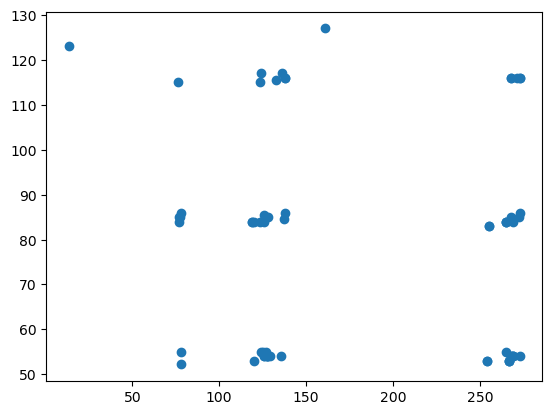

In [19]:
plt.scatter(all_kills_df.center_x, all_kills_df.center_y)

In [40]:
(top_left, top_right, bottom_right, bottom_left) = bbox_list

In [41]:
center_x = (top_left[0] + top_right[0]) / 2
center_y = (top_left[1] + bottom_left[1]) / 2
print(center_x, center_y)

122.0 55.0


In [44]:
all_kills_df.loc[all_kills_df['text'] == '']

,Unnamed: 0,bbox,text,conf,time_s


In [45]:
all_kills_df['bbox'] = all_kills_df['bbox'].apply(ast.literal_eval)

In [59]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s,center_x,center_y
0,0,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.997456,25.466667,122.0,55.0
1,1,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.516252,25.466667,265.0,54.0
2,2,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.996899,25.500000,122.0,55.0
3,3,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.515822,25.500000,265.0,54.0
4,4,"[[93, 47], [151, 47], [151, 65], [93, 65]]",cLouding,0.996799,25.533333,122.0,56.0
...,...,...,...,...,...,...,...
1946,1946,"[[17, 137], [67, 137], [67, 155], [17, 155]]",100%0,0.815344,50.800000,42.0,146.0
1947,1947,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.865404,50.833333,42.0,145.0
1948,1948,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.580753,50.866667,42.0,145.0
1949,1949,"[[25, 135], [65, 135], [65, 153], [25, 153]]",00P0,0.197704,50.900000,45.0,144.0


In [47]:
all_kills_df[all_kills_df['text'].isna()]

,Unnamed: 0,bbox,text,conf,time_s
1814,1814,"[[105, 79], [137, 79], [137, 91], [105, 91]]",NaN,0.0,37.366667


In [48]:
all_kills_df.dropna(inplace=True)

In [49]:
all_kills_df

,Unnamed: 0,bbox,text,conf,time_s
0,0,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.997456,25.466667
1,1,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.516252,25.466667
2,2,"[[93, 47], [151, 47], [151, 63], [93, 63]]",cLouding,0.996899,25.500000
3,3,"[[241, 47], [289, 47], [289, 61], [241, 61]]",Nitara,0.515822,25.500000
4,4,"[[93, 47], [151, 47], [151, 65], [93, 65]]",cLouding,0.996799,25.533333
...,...,...,...,...,...
1946,1946,"[[17, 137], [67, 137], [67, 155], [17, 155]]",100%0,0.815344,50.800000
1947,1947,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.865404,50.833333
1948,1948,"[[17, 137], [67, 137], [67, 153], [17, 153]]",100%0,0.580753,50.866667
1949,1949,"[[25, 135], [65, 135], [65, 153], [25, 153]]",00P0,0.197704,50.900000


In [57]:
x_1 = int(820 / 1920 * 1280)
x_2 = int(1100 / 1920 * 1280)
w = x_2 - x_1
y_1 = 0
y_2 = int(50 / 1080 * 720)
h = y_2 - y_1
print(x_1, x_2, y_1, y_2, w, h)

546 733 0 33 187 33


In [58]:
x_1 = int(1450 / 1920 * 1280)
x_2 = int(1920 / 1920 * 1280)
w = x_2 - x_1
y_1 = 0
y_2 = int(310 / 1080 * 720)
h = y_2 - y_1
print(x_1, x_2, y_1, y_2, w, h)

966 1280 0 206 314 206


In [5]:
all_time_df = pd.read_csv('all_time.csv')
all_time_df['bbox'] = all_time_df['bbox'].apply(ast.literal_eval)

In [6]:
all_time_df

,Unnamed: 0,bbox,text,conf,time_s,current_frame
0,0,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.033333,1
1,1,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.360755,0.033333,1
2,2,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.066667,2
3,3,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.362643,0.066667,2
4,4,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.100000,3
...,...,...,...,...,...,...
5127,5127,"[[4, 6], [46, 6], [46, 36], [4, 36]]",10,0.999981,89.600000,2688
5128,5128,"[[60, 8], [128, 8], [128, 32], [60, 32]]",00 04,0.856225,89.600000,2688
5129,5129,"[[146, 6], [186, 6], [186, 38], [146, 38]]",12,0.999993,89.600000,2688
5130,5130,"[[6, 6], [46, 6], [46, 36], [6, 36]]",10,0.999590,89.633333,2689


In [7]:
centers_x = []
centers_y = []
for i, row in all_time_df.iterrows():
    (top_left, top_right, bottom_right, bottom_left) = row['bbox']
    centers_x.append((top_left[0] + top_right[0]) / 2)
    centers_y.append((top_left[1] + bottom_left[1]) / 2)
all_time_df['center_x'] = centers_x
all_time_df['center_y'] = centers_y

In [12]:
all_time_df = all_time_df.drop(['Unnamed: 0'], axis=1)

In [13]:
all_time_df

,bbox,text,conf,time_s,current_frame,center_x,center_y
0,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.033333,1,24.0,21.0
1,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.360755,0.033333,1,94.0,21.0
2,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.066667,2,24.0,21.0
3,"[[60, 8], [128, 8], [128, 34], [60, 34]]",00;12,0.362643,0.066667,2,94.0,21.0
4,"[[12, 8], [36, 8], [36, 34], [12, 34]]",0,0.999983,0.100000,3,24.0,21.0
...,...,...,...,...,...,...,...
5127,"[[4, 6], [46, 6], [46, 36], [4, 36]]",10,0.999981,89.600000,2688,25.0,21.0
5128,"[[60, 8], [128, 8], [128, 32], [60, 32]]",00 04,0.856225,89.600000,2688,94.0,20.0
5129,"[[146, 6], [186, 6], [186, 38], [146, 38]]",12,0.999993,89.600000,2688,166.0,22.0
5130,"[[6, 6], [46, 6], [46, 36], [6, 36]]",10,0.999590,89.633333,2689,26.0,21.0


In [66]:
model = KMeans(n_clusters=3)
# model = DBSCAN()

In [67]:
time_center_x: pd.Series = all_time_df['center_x']
model.fit(time_center_x.values.reshape(-1, 1))

C:\Users\mrbab\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3)

In [68]:
all_time_df['x_clusters'] = model.labels_

In [76]:
all_time_df[['current_frame', 'center_x']]

,current_frame,center_x
0,1,24.0
1,1,94.0
2,2,24.0
3,2,94.0
4,3,24.0
...,...,...
5127,2688,25.0
5128,2688,94.0
5129,2688,166.0
5130,2689,26.0


In [94]:
all_time_df[['current_frame', 'center_x']].groupby('current_frame').count().query('center_x > 3')

,center_x
current_frame,


Text(0.5, 1.0, 'Clusters according x-axis')

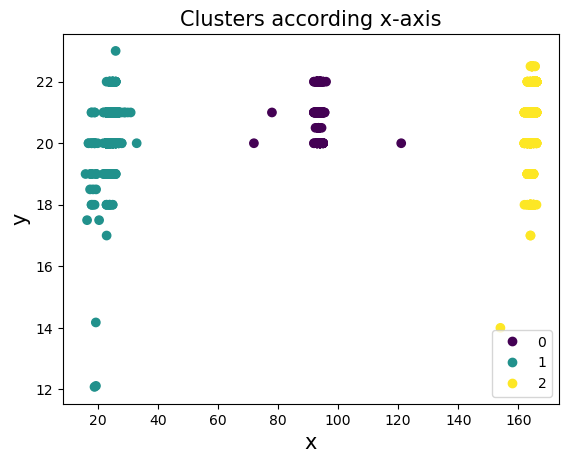

In [69]:
sc = plt.scatter(all_time_df['center_x'], all_time_df['center_y'], c=all_time_df['x_clusters'])
handles, labels = sc.legend_elements()
plt.legend(handles, labels, loc='lower right')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Clusters according x-axis', fontsize=15)

In [107]:
sorted_clusters_by_center_x: pd.DataFrame = all_time_df[['x_clusters', 'center_x']].groupby('x_clusters').mean().sort_values(by='center_x', ascending=True)

In [132]:
left_x_cluster = sorted_clusters_by_center_x.index.tolist()[0]
center_x_cluster = sorted_clusters_by_center_x.index.tolist()[1]
right_x_cluster = sorted_clusters_by_center_x.index.tolist()[2]

In [240]:
formatted_time = pd.DataFrame(columns=['left_score', 'center_score', 'right_score', 'time_s'])
# formatted_time['frame'] = np.sort(all_time_df['current_frame'].unique())

In [241]:
formatted_time

,left_score,center_score,right_score,time_s


In [178]:
all_time_df.columns

Index(['bbox', 'text', 'conf', 'time_s', 'current_frame', 'center_x',
       'center_y', 'x_clusters', 'y_clusters'],
      dtype='object')

In [242]:
# 0 - bbox , 1 - text, 2 - conf, 3 - time_s, 4 - center_x, 5 - center_y, 6 - x_clusters, 7 - y_clusters
detection_column = {
    left_x_cluster: 'left_score',
    center_x_cluster: 'center_score',
    right_x_cluster: 'right_score'
}
for frame, group in all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()).items():
    add_row = pd.DataFrame(columns=['frame', 'time_s', 'left_score', 'center_score', 'right_score'])
    add_row['frame'] = [int(frame)]
    for note in group:
        add_row['time_s'] = note[3]
        add_row[detection_column.get(note[7])] = [note[1]]
    formatted_time = pd.concat([formatted_time, add_row], ignore_index=True)

left_score
[[[12, 8], [36, 8], [36, 34], [12, 34]], '0', 0.9999829531442436, 0.0333333333333333, 1, 24.0, 21.0, 1, 0]
center_score
[[[60, 8], [128, 8], [128, 34], [60, 34]], '00;12', 0.3607553832794313, 0.0333333333333333, 1, 94.0, 21.0, 0, 0]
left_score
[[[12, 8], [36, 8], [36, 34], [12, 34]], '0', 0.9999829531442436, 0.0666666666666666, 2, 24.0, 21.0, 1, 0]
center_score
[[[60, 8], [128, 8], [128, 34], [60, 34]], '00;12', 0.3626432921788761, 0.0666666666666666, 2, 94.0, 21.0, 0, 0]
left_score
[[[12, 8], [36, 8], [36, 34], [12, 34]], '0', 0.9999828339359738, 0.1, 3, 24.0, 21.0, 1, 0]
center_score
[[[60, 8], [128, 8], [128, 34], [60, 34]], '00;12', 0.3626303330213453, 0.1, 3, 94.0, 21.0, 0, 0]
center_score
[[[60, 10], [124, 10], [124, 34], [60, 34]], '00;1n1', 0.1960516369038525, 0.1333333333333333, 4, 92.0, 22.0, 0, 1]
center_score
[[[59, 7], [128, 7], [128, 35], [59, 35]], '00:10', 0.5963825594947803, 0.1666666666666666, 5, 93.5, 21.0, 0, 0]
center_score
[[[60, 8], [126, 8], [126, 34]

In [246]:
formatted_time['frame'] = formatted_time['frame'].apply(int)

In [249]:
formatted_time.to_csv('formatted_time.csv', index=False)

In [244]:
formatted_time.to_csv('formatted_time.csv')

In [212]:
for frame, row in all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()).items():
    
    break

1 [[[[12, 8], [36, 8], [36, 34], [12, 34]], '0', 0.9999829531442436, 0.0333333333333333, 1, 24.0, 21.0, 1, 0], [[[60, 8], [128, 8], [128, 34], [60, 34]], '00;12', 0.3607553832794313, 0.0333333333333333, 1, 94.0, 21.0, 0, 0]]


In [204]:
pd.DataFrame(all_time_df.groupby('current_frame').apply(lambda x: x.values.tolist()))

,0
current_frame,
1,"[[[[12, 8], [36, 8], [36, 34], [12, 34]], 0, 0..."
2,"[[[[12, 8], [36, 8], [36, 34], [12, 34]], 0, 0..."
3,"[[[[12, 8], [36, 8], [36, 34], [12, 34]], 0, 0..."
4,"[[[[60, 10], [124, 10], [124, 34], [60, 34]], ..."
5,"[[[[59, 7], [128, 7], [128, 35], [59, 35]], 00..."
...,...
2685,"[[[[6, 6], [46, 6], [46, 36], [6, 36]], 10, 0...."
2686,"[[[[4, 6], [46, 6], [46, 36], [4, 36]], 10, 0...."
2687,"[[[[4, 6], [46, 6], [46, 36], [4, 36]], 10, 0...."


In [35]:
center_x_cluster
y_model = DBSCAN()
y_model.fit(all_time_df['center_y'].values.reshape(-1, 1))

DBSCAN()

In [39]:
np.unique(y_model.labels_)

array([-1,  0,  1,  2], dtype=int64)

In [40]:
all_time_df['y_clusters'] = y_model.labels_

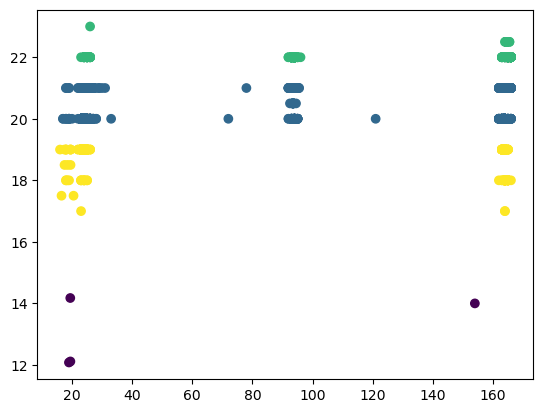

In [42]:
plt.scatter(all_time_df['center_x'], all_time_df['center_y'], c=all_time_df['y_clusters'])

In [24]:
all_time_df['center_x']

0        24.0
1        94.0
2        24.0
3        94.0
4        24.0
        ...  
5127     25.0
5128     94.0
5129    166.0
5130     26.0
5131    165.0
Name: center_x, Length: 5132, dtype: float64

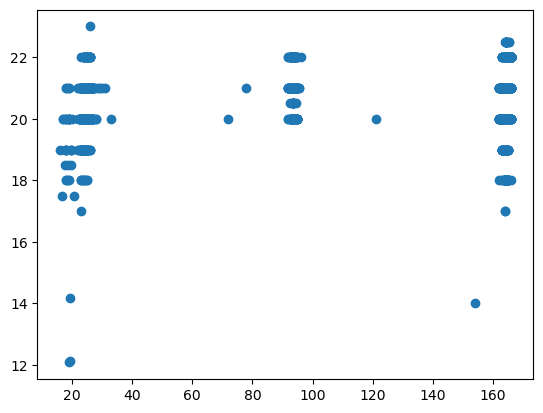

In [14]:
plt.scatter(all_time_df.center_x, all_time_df.center_y)